In [1]:
%load_ext autoreload
%autoreload 2

from pytorch3d.io import load_objs_as_meshes
import torch

from pytorch3d.renderer import FoVPerspectiveCameras

from text3d2video.util import read_obj_uvs
from text3d2video.utilities.mesh_processing import normalize_meshes

torch.set_grad_enabled(False)

# read mesh
mesh_path = "data/meshes/mixamo-human.obj"

device = "cuda"
meshes = load_objs_as_meshes([mesh_path], device=device)
meshes = normalize_meshes(meshes)
verts_uvs, faces_uvs = read_obj_uvs(mesh_path)

print('verts', meshes.verts_list()[0].shape)
print('faces', meshes.faces_list()[0].shape)

/home/jorge/miniconda3/envs/thesis4/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


verts torch.Size([14442, 3])
faces torch.Size([28880, 3])


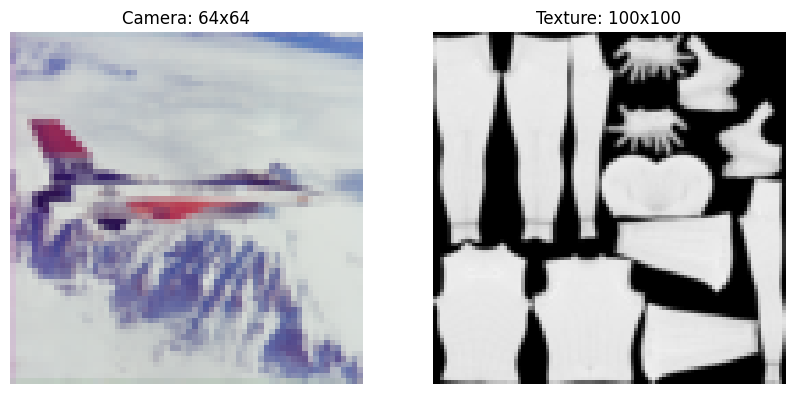

In [2]:
from matplotlib import pyplot as plt
import torch
from pytorch3d.renderer import TexturesUV
from torchvision.io import read_image
import torchvision.transforms.functional as TF

TEXTURE_RES = 100
CAMERA_RES = 64

texture_image = read_image("data/meshes/mixamo-human_uvs.png") / 255
texture_image = TF.resize(texture_image, (TEXTURE_RES, TEXTURE_RES))
texture_image = texture_image[0:3, :, :]
texture_image = texture_image.permute(1, 2, 0).to(device)

camera_image = read_image("data/images/airplane.png") / 255
camera_image = TF.resize(camera_image, (CAMERA_RES, CAMERA_RES))
camera_image = camera_image.permute(1, 2, 0).to(device)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax_tex = axs[1]
ax_cam = axs[0]

ax_tex.set_title(f"Texture: {TEXTURE_RES}x{TEXTURE_RES}")
ax_tex.imshow(texture_image.cpu().numpy())

ax_cam.set_title(f"Camera: {CAMERA_RES}x{CAMERA_RES}")
ax_cam.imshow(camera_image.cpu().numpy())

for ax in axs:
    ax.axis("off")

(-0.5, 511.5, 511.5, -0.5)

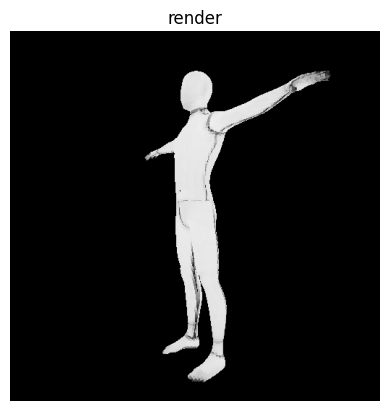

In [3]:
from text3d2video.rendering import TextureShader
from pytorch3d.renderer import MeshRenderer
from text3d2video.rendering import make_mesh_rasterizer
from text3d2video.utilities.camera_placement import turntable_extrinsics

R, T = turntable_extrinsics(angles=60, dists=1)
cam = FoVPerspectiveCameras(R=R, T=T, device=device, fov=65)

textures = TexturesUV(
    maps=texture_image.unsqueeze(0),
    verts_uvs=verts_uvs.unsqueeze(0),
    faces_uvs=faces_uvs.unsqueeze(0),
)

meshes.textures = textures
meshes.textures.sampling_mode = "nearest"

shader = TextureShader()
rasterizer = make_mesh_rasterizer()
renderer = MeshRenderer(rasterizer=rasterizer, shader=shader)

frames = renderer(meshes, cameras=cam)

plt.title("render")
plt.imshow(TF.to_pil_image(frames[0].cpu()))
plt.axis("off")

In [4]:
from text3d2video.backprojection import project_visible_texels_to_camera

texel_xys, texel_uvs = project_visible_texels_to_camera(
    meshes, cam, verts_uvs, faces_uvs, raster_res=2000, texture_res=TEXTURE_RES
)

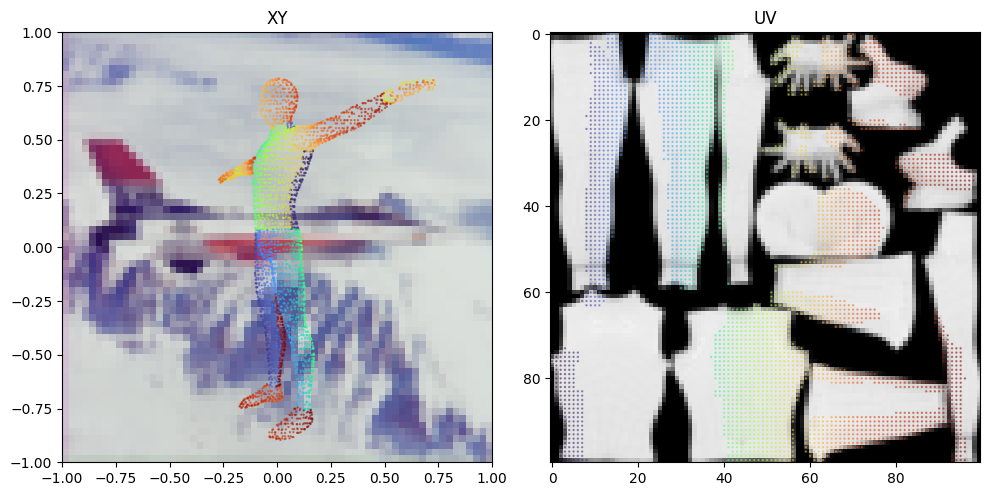

In [5]:
indices = torch.arange(0, texel_xys.shape[0], device=device)

cmap = "turbo"
s = 0.5
alpha = 0.5

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax_xy = axs[0]
ax_uv = axs[1]

ax_xy.imshow(camera_image.cpu().numpy(), extent=(-1, 1, -1, 1))
ax_xy.set_xlim(-1, 1)
ax_xy.set_ylim(-1, 1)
ax_xy.set_title("XY")

ax_xy.scatter(
    texel_xys[:, 0].cpu(),
    texel_xys[:, 1].cpu(),
    s=s,
    c=indices.cpu(),
    cmap=cmap,
    alpha=alpha,
)

ax_uv.imshow(texture_image.cpu().numpy())
ax_uv.scatter(
    texel_uvs[:, 0].cpu(),
    texel_uvs[:, 1].cpu(),
    s=s,
    c=indices.cpu(),
    cmap=cmap,
    alpha=alpha,
)
ax_uv.set_title("UV")

plt.tight_layout()
plt.show()

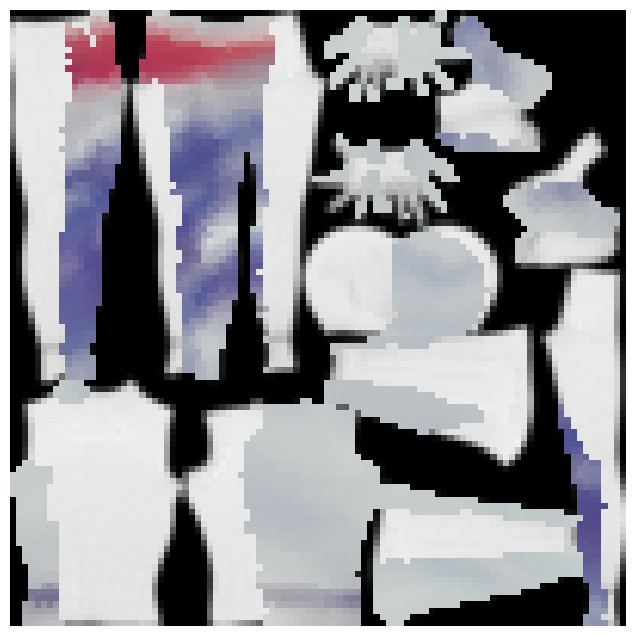

<Figure size 640x480 with 0 Axes>

In [11]:
from text3d2video.backprojection import update_uv_texture
from text3d2video.ipython_utils import display_ims

camera_fmap = camera_image.permute(2, 0, 1)

updated_texture = texture_image.clone()
updated_texture = update_uv_texture(
    updated_texture, camera_fmap, texel_xys, texel_uvs, update_unfilled=False
)

display_ims([updated_texture.cpu()], scale=8)

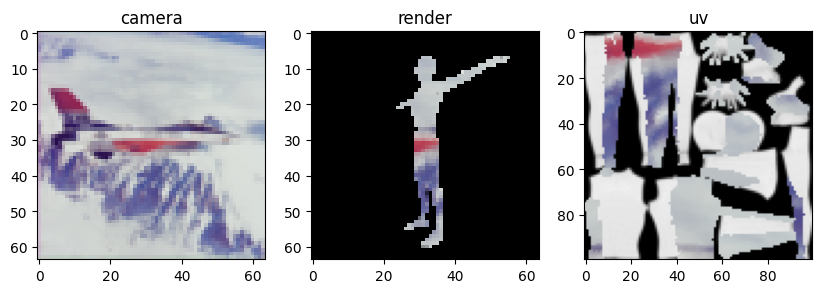

In [24]:
textures = TexturesUV(
    maps=updated_texture.unsqueeze(0),
    verts_uvs=verts_uvs.unsqueeze(0),
    faces_uvs=faces_uvs.unsqueeze(0),
)

meshes.textures = textures

rasterizer = make_mesh_rasterizer(resolution=CAMERA_RES)
renderer = MeshRenderer(rasterizer=rasterizer, shader=TextureShader())

frames = renderer(meshes, cameras=cam)

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

ax_cam = axs[0]
ax_render = axs[1]
ax_uv = axs[2]

ax_render.set_title("render")
ax_render.imshow(frames[0].cpu().permute(1, 2, 0))

ax_cam.set_title("camera")
ax_cam.imshow(camera_image.cpu())

ax_uv.set_title("uv")
ax_uv.imshow(updated_texture.cpu())

In [23]:
import torchvision.transforms.functional as TF

from text3d2video.rendering import make_mesh_renderer
from text3d2video.utilities.ipython_utils import display_vid
from text3d2video.utilities.video_util import pil_frames_to_clip

R, T = turntable_extrinsics(1, torch.linspace(0, 360, 30))
cams = FoVPerspectiveCameras(R=R, T=T, device=device, fov=60)
frame_meshes = meshes.extend(len(R))

renderer = make_mesh_renderer(resolution=100)
frames = renderer(frame_meshes, cameras=cams)

frames = [TF.to_pil_image(frame.cpu()) for frame in frames]
display_vid(pil_frames_to_clip(frames), resolution=300)